In [35]:
import seaborn 
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVR
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder,KBinsDiscretizer
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score,KFold
from sklearn.metrics import r2_score,mean_squared_error,roc_curve,confusion_matrix,accuracy_score

In [88]:
df = pd.read_csv('predictionQuery_Train.csv')
df.head(50)

,lon,lat,Nazov,DELAY,Current_Stop,From,Destination,Current_Time,Current_Day,Current_Hour,Current_Minutes,Current_Seconds
0,21.905060,49.261860,Os 8912,0,Medzilaborce,Medzilaborce mesto,Humenné,1611826953497,28,10,42,33
1,21.905060,49.261860,Os 8912,0,Medzilaborce,Medzilaborce mesto,Humenné,1611826967497,28,10,42,47
2,21.905060,49.261860,Os 8912,0,Medzilaborce,Medzilaborce mesto,Humenné,1611827013558,28,10,43,33
3,21.905060,49.261860,Os 8912,0,Medzilaborce,Medzilaborce mesto,Humenné,1611827027546,28,10,43,47
4,20.526370,49.255290,Os 8311,0,Podolínec,Poprad-Tatry,Stará Ľubovňa,1611827237672,28,10,47,17
5,21.519728,49.019015,Os 9112,0,Hanušovce nad Topľou,Humenné,Prešov,1611827447718,28,10,50,47
6,21.320440,49.043860,Os 9213,0,Kapušany pri Prešove,Prešov,Bardejov,1611827447718,28,10,50,47
7,21.519728,49.019015,Os 9112,0,Hanušovce nad Topľou,Humenné,Prešov,1611827462733,28,10,51,2
8,21.320440,49.043860,Os 9213,0,Kapušany pri Prešove,Prešov,Bardejov,1611827462733,28,10,51,2
9,21.519728,49.019015,Os 9112,0,Hanušovce nad Topľou,Humenné,Prešov,1611827477746,28,10,51,17


In [89]:
df.describe()

,lon,lat,DELAY,Current_Time,Current_Day,Current_Hour,Current_Minutes,Current_Seconds
count,13519.000000,13519.000000,13519.000000,1.351900e+04,13519.000000,13519.000000,13519.000000,13519.00000
mean,21.337290,48.895414,186.164657,1.611859e+12,28.302833,11.757970,28.043864,29.22265
std,0.449407,0.166099,596.790414,5.268188e+07,0.682578,5.547519,16.129692,17.50192
min,20.471821,48.390320,-360.000000,1.611759e+12,27.000000,0.000000,0.000000,0.00000
25%,21.013240,48.811670,0.000000,1.611814e+12,28.000000,6.000000,14.000000,12.00000
50%,21.268720,48.874030,0.000000,1.611854e+12,28.000000,12.000000,26.000000,29.00000
75%,21.751880,48.983379,180.000000,1.611901e+12,29.000000,16.000000,41.000000,46.00000
max,22.218141,49.308340,6300.000000,1.611944e+12,29.000000,23.000000,59.000000,59.00000


In [90]:
df.isnull().sum()

lon                0
lat                0
Nazov              0
DELAY              0
Current_Stop       0
From               0
Destination        0
Current_Time       0
Current_Day        0
Current_Hour       0
Current_Minutes    0
Current_Seconds    0
dtype: int64

In [91]:
df.dtypes

lon                float64
lat                float64
Nazov               object
DELAY                int64
Current_Stop        object
From                object
Destination         object
Current_Time         int64
Current_Day          int64
Current_Hour         int64
Current_Minutes      int64
Current_Seconds      int64
dtype: object

In [92]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('Current_Time', 'Current_Day')]

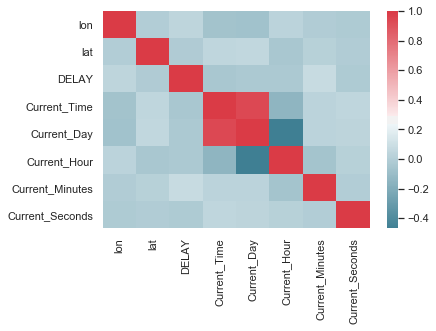

In [93]:
seaborn.set(style='white')
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
seaborn.heatmap(df.corr(),cmap=cmap)

In [94]:
df = df.drop("Current_Time",axis = 1)

In [95]:
def LabelEncoding(col):
    encoder = LabelEncoder()
    encoder.fit(df[col])
    list(encoder.classes_)
    return encoder.transform(df[col])

def KBinsDiscretizing(currCol):
    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    discretizer.fit(df[currCol])
    return discretizer.transform(df[currCol])

df['Current_Stop_Encoded']=LabelEncoding('Current_Stop')
df['From_Encoded']=LabelEncoding('From')
df['Destination_Encoded']=LabelEncoding('Destination')
df['lon_Encoded']=LabelEncoding('lon')
df['lat_Encoded']=LabelEncoding('lat')
df['Current_Seconds_Encoded']=LabelEncoding('Current_Seconds')
df['Current_Minutes_Encoded']=LabelEncoding('Current_Minutes')
df['Current_Hour_Encoded']= LabelEncoding('Current_Hour')
df['Current_Day_Encoded']= LabelEncoding('Current_Day')
df['Nazov_Encoded'] = LabelEncoding('Nazov')

In [96]:
df.head()

,lon,lat,Nazov,DELAY,Current_Stop,From,Destination,Current_Day,Current_Hour,Current_Minutes,...,Current_Stop_Encoded,From_Encoded,Destination_Encoded,lon_Encoded,lat_Encoded,Current_Seconds_Encoded,Current_Minutes_Encoded,Current_Hour_Encoded,Current_Day_Encoded,Nazov_Encoded
0,21.90506,49.26186,Os 8912,0,Medzilaborce,Medzilaborce mesto,Humenné,28,10,42,...,28,14,6,57,68,33,42,9,1,157
1,21.90506,49.26186,Os 8912,0,Medzilaborce,Medzilaborce mesto,Humenné,28,10,42,...,28,14,6,57,68,47,42,9,1,157
2,21.90506,49.26186,Os 8912,0,Medzilaborce,Medzilaborce mesto,Humenné,28,10,43,...,28,14,6,57,68,33,43,9,1,157
3,21.90506,49.26186,Os 8912,0,Medzilaborce,Medzilaborce mesto,Humenné,28,10,43,...,28,14,6,57,68,47,43,9,1,157
4,20.52637,49.25529,Os 8311,0,Podolínec,Poprad-Tatry,Stará Ľubovňa,28,10,47,...,38,18,24,3,67,17,47,9,1,78


In [97]:
df = df.drop(['Nazov','Current_Stop','Current_Hour','Current_Minutes',
              'Current_Seconds','lon','lat',"Destination","From",
              'Current_Day'],axis =1, errors='ignore')

,DELAY,Current_Stop_Encoded,From_Encoded,Destination_Encoded,lon_Encoded,lat_Encoded,Current_Seconds_Encoded,Current_Minutes_Encoded,Current_Hour_Encoded,Current_Day_Encoded,Nazov_Encoded
0,0,28,14,6,57,68,33,42,9,1,157
1,0,28,14,6,57,68,47,42,9,1,157
2,0,28,14,6,57,68,33,43,9,1,157
3,0,28,14,6,57,68,47,43,9,1,157
4,0,38,18,24,3,67,17,47,9,1,78
5,0,8,6,21,39,57,47,50,9,1,189
6,0,14,19,1,34,58,47,50,9,1,211
7,0,8,6,21,39,57,2,51,9,1,189
8,0,14,19,1,34,58,2,51,9,1,211
9,0,8,6,21,39,57,17,51,9,1,189


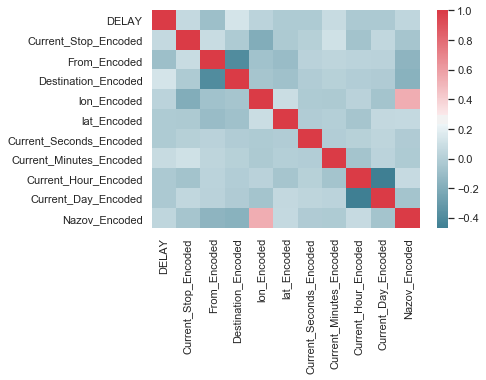

In [98]:
seaborn.heatmap(df.corr(),cmap=cmap)
df.head(10)

In [99]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.5)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('lon_Encoded', 'Nazov_Encoded')]

In [100]:
df = df.drop('lon_Encoded',axis =1, errors='ignore')

In [101]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


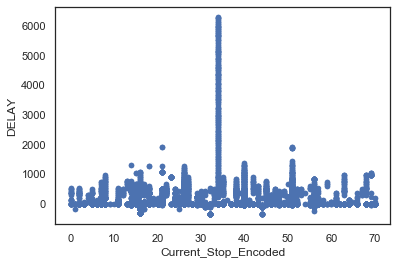

<Figure size 60000x30000 with 0 Axes>

In [102]:
df.plot(x ='Current_Stop_Encoded', y='DELAY', kind='scatter')
plt.figure(i, figsize=(200, 100),dpi=300)
plt.show()

<Figure size 6000x3000 with 0 Axes>

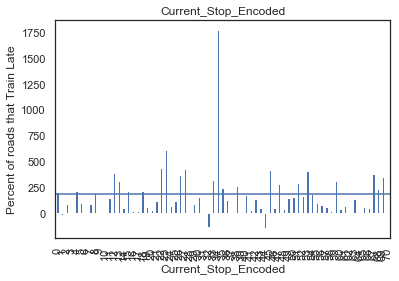

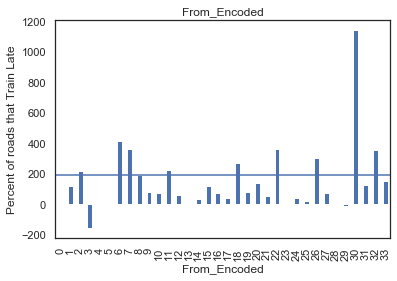

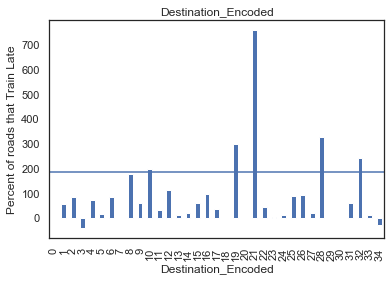

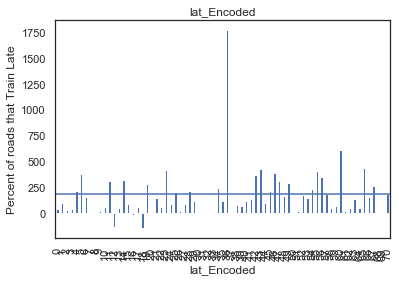

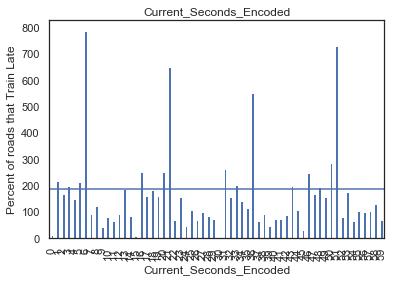

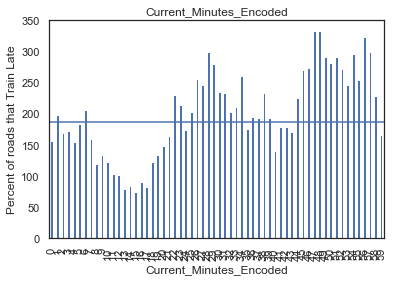

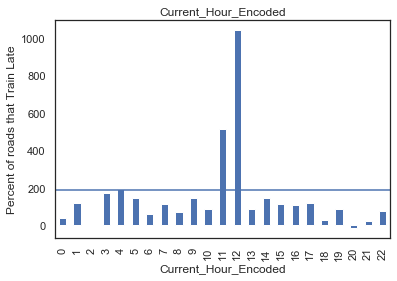

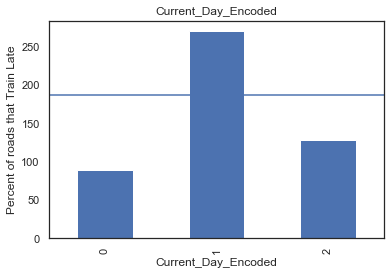

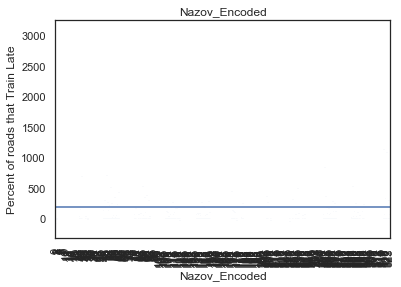

In [67]:
avgLate = np.sum(df['DELAY'])/len(df['DELAY'])
attributes = ['Current_Stop_Encoded','From_Encoded','Destination_Encoded','lat_Encoded',
              'Current_Seconds_Encoded','Current_Minutes_Encoded','Current_Hour_Encoded',
              'Current_Day_Encoded','Nazov_Encoded']
for i,pred in enumerate(attributes):
    plt.figure(i, figsize=(20, 10),dpi=300)
    group = df.groupby([pred], as_index=False).aggregate(np.mean)[[pred, 'DELAY']]
    group.sort_values(by=pred, inplace=True)    
    group.plot.bar(x=pred, y='DELAY')
    plt.axhline(y=avgLate, label='Average')
    plt.ylabel('Percent of roads that Train Late')
    plt.title(pred)
    plt.legend().remove()

In [26]:
train_x, test_x, train_y, test_y = train_test_split(df.drop('DELAY', axis=1), df['DELAY'], test_size=0.3, random_state=1234)

In [50]:
print(train_x.shape +  test_x.shape)

(9463, 9, 4056, 9)


In [51]:
print(train_y.shape +  test_y.shape)

(9463, 4056)


#### GridSearch for RandomForest

In [28]:
startTimeGS = datetime.now()
param_grid = {'n_estimators': [10,15,20,25,100,500,600,700,800,900,1000]}

grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=10)
grid_rf.fit(train_x, train_y)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.score
print('Random forest Grid Search with non-redundant variables took [', datetime.now() - startTimeGS, '] seconds.')

Random forest Grid Search with non-redundant variables took [ 0:12:32.851889 ] seconds.


In [29]:
print(bestModel)
print(bestParameters)
gridScores

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
{'n_estimators': 800}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False)

#### RandomForest

In [30]:
regr = RandomForestRegressor(n_estimators = bestParameters.get('n_estimators'),
                             random_state = 1234)
regr.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
#y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred_svr = regr.predict(test_x)
regr.score(test_x,test_y)

0.9939549491549208
0.0025952694971324726
[0.99588579 0.98933351 0.99406347 0.98866413 0.99442957 0.99507253
 0.99421931 0.9955714  0.99569269 0.99661709]


0.9913684072276316

In [31]:
y_pred= y_pred_svr
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 15.991752958579882
Mean Squared Error (MSE): 2376.139390717455
Root Mean Squared Error (RMSE): 48.74566022444927
Explained Variance Score: 0.9913684481223055
Max Error: 729.0
Median Absolute Error: 0.9
R^2: 0.9913684072276315


#### GridSearch for Linear Regression

In [32]:
param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True,False]}
grid_search = GridSearchCV(LinearRegression(), param_grid, cv = 10)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
{'copy_X': True, 'fit_intercept': False, 'normalize': True}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)>

#### LinearRegression

In [33]:
regressor = LinearRegression(fit_intercept=bestParameters.get('fit_intercept'),
                             normalize=bestParameters.get('normalize'), 
                             copy_X=bestParameters.get('copy_X'))  
regressor.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(regressor, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
#y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred = regressor.predict(test_x)
regressor.score(test_x,test_y)

0.03448626348310922
0.008388913232714065
[0.03762781 0.03335751 0.01396943 0.02860866 0.03813095 0.04123273
 0.04389149 0.04217572 0.03653319 0.02933516]


0.026140469635928976

In [34]:
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 257.17684035872236
Mean Squared Error (MSE): 268087.9476301691
Root Mean Squared Error (RMSE): 517.7721000886096
Explained Variance Score: 0.02793487537884931
Max Error: 5802.788453050202
Median Absolute Error: 170.1919986142504
R^2: 0.026140469635928976


#### GridsearchCV for SVR

In [103]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 10, 100,1.0], 'gamma' : [0.001, 0.01, 0.1,1.0,'scale']}
grid_search = GridSearchCV(SVR(), param_grid, cv = 10)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
{'C': 100, 'gamma': 0.01}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 10, 100, 1.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 'scale']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)>

#### SVR

In [104]:
svr_rbf = SVR(kernel='rbf', 
              C=bestParameters.get('C'),
              gamma=bestParameters.get('gamma'), epsilon=1)
svr_rbf.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(svr_rbf, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
#y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)
y_pred_svr = svr_rbf.predict(test_x)
svr_rbf.score(test_x,test_y)

0.4769361601944759
0.022713036379935332
[0.51934384 0.49296497 0.46182828 0.48690511 0.43511881 0.50217009
 0.46296261 0.46561018 0.47029844 0.47215927]


0.4633983595501636

In [105]:
y_pred= y_pred_svr
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 104.08191489614988
Mean Squared Error (MSE): 147717.84636065408
Root Mean Squared Error (RMSE): 384.34079455693234
Explained Variance Score: 0.4801421571813509
Max Error: 5240.800169146022
Median Absolute Error: 7.864503295182445
R^2: 0.4633983595501636


#### GridSearch for XGBoost model

In [39]:
param_grid = {'max_depth' : [1,2,3,4,5,6,7,8,9,10],
              'n_estimators': [10,15,20,25,100,500,600,700,800,900,1000]
             }
grid_search = GridSearchCV(xgb.XGBRegressor(objective ='reg:squarederror'), param_grid, cv = 10)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
{'max_depth': 7, 'n_estimators': 1000}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  

#### XGBoost model

In [40]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.8, 
                          learning_rate = 1,
                          max_depth = bestParameters.get('max_depth'), 
                          alpha = 10, 
                          n_estimators = bestParameters.get('n_estimators'))
xg_reg.fit(train_x,train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores= cross_val_score(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
#y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)

preds_y = xg_reg.predict(test_x)
rmse = np.sqrt(mean_squared_error(test_y, preds_y))
print(xg_reg.score(test_x,test_y))

0.9892688336565814
0.004990504414506834
[0.9908587  0.9752238  0.98901501 0.98763689 0.99207722 0.9917982
 0.99136    0.99411777 0.98924328 0.99135746]
0.9762551771781085


In [41]:
y_pred= preds_y
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 32.94714550035445
Mean Squared Error (MSE): 6536.569822121174
Root Mean Squared Error (RMSE): 80.84905578991739
Explained Variance Score: 0.9763148108806347
Max Error: 2161.6748046875
Median Absolute Error: 13.64217758178711
R^2: 0.9762551771781085


#### GridSearch for DecisionTree

In [45]:
startTimeGS = datetime.now()
param_grid = {'criterion':['mse', 'friedman_mse', 'mae'],
              'splitter':['best','random']}

grid_rf = GridSearchCV(DecisionTreeRegressor(random_state =  0), param_grid, cv=10)
grid_rf.fit(train_x, train_y)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.score
print('MLPRegressor Grid Search with non-redundant variables took [', datetime.now() - startTimeGS, '] seconds.')

MLPRegressor Grid Search with non-redundant variables took [ 0:01:02.445001 ] seconds.


In [46]:
print(bestModel)
print(bestParameters)
gridScores

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='random')
{'criterion': 'mse', 'splitter': 'random'}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'splitter': ['best', 'random']},
             pre_dispatch='2*n_jobs', 

In [47]:
regr = DecisionTreeRegressor(criterion = bestParameters.get('criterion'),
                             splitter = bestParameters.get('splitter'))
regr.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
#y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred_svr = regr.predict(test_x)
regr.score(test_x,test_y)

0.9915110090839203
0.0066808539116221845
[0.99496161 0.98682859 0.99362579 0.99278006 0.99423286 0.99607944
 0.97281803 0.99434861 0.99494273 0.99449238]


0.9887442760847859

In [48]:
y_pred= y_pred_svr
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 11.967455621301776
Mean Squared Error (MSE): 3098.5207100591715
Root Mean Squared Error (RMSE): 55.66435762729299
Explained Variance Score: 0.9887643725597098
Max Error: 1140.0
Median Absolute Error: 0.0
R^2: 0.9887442760847859
